In [10]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
local_path = '/content/drive/MyDrive/Colab Notebooks/5511/Week_3/histopathologic-cancer-detection/'

### Problem Description and Data Analysis

#### Challenge Problem
The task is to develop a machine learning model to identify metastatic cancer in small image patches from larger digital pathology scans. The challenge is evaluated on the area under the ROC curve metric, emphasizing both sensitivity and specificity in the detection.

#### Data
The dataset consists of small pathology images, each labeled as 0 or 1, indicating the absence or presence of metastatic cancer. Each image is in `.tif` format and has a size of 96x96 pixels. We have a training dataset with labels and a test dataset without labels, for which we need to predict the probabilities.

### Exploratory Data Analysis (EDA)

In [15]:
df = pd.read_csv(local_path + "modified_train_labels.csv")

print(df.info())

print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106999 entries, 0 to 106998
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      106999 non-null  object
 1   label   106999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None
0    63536
1    43463
Name: label, dtype: int64


In [21]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
3,acfe80838488fae3c89bd21ade75be5c34e66be7,0
4,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1


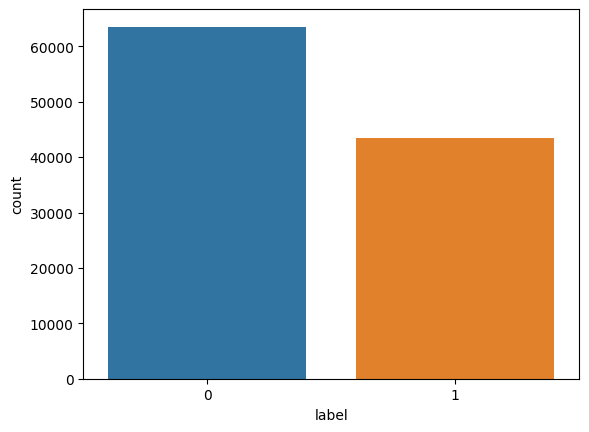

In [16]:
# Visualize the distribution of labels
sns.countplot(x="label", data=df)
plt.show()


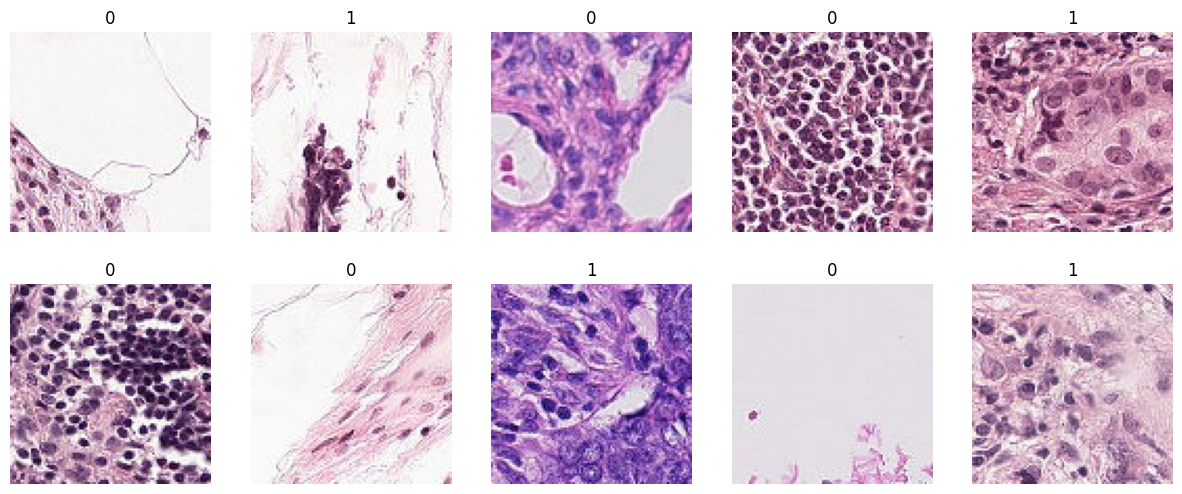

In [17]:
# display images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.ravel()

for i in range(10):
    img = Image.open(os.path.join(local_path + 'train', df.id[i] + '.tif'))
    axs[i].imshow(img)
    axs[i].set_title(df.label[i])
    axs[i].axis('off')


### Building the Model

In [18]:
# Building the model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(96, 96, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 3.2 Data Preprocessing and Augmentation

Using the `ImageDataGenerator` class in Keras

In [24]:
df['label'] = df['label'].astype(str)

# Splitting the data again after converting the label to string
train_df, val_df = train_test_split(df, test_size=0.2, random_state=101)


In [25]:
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/5511/Week_3/histopathologic-cancer-detection/train'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/5511/Week_3/histopathologic-cancer-detection/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    batch_size=32,
    shuffle=True,
    class_mode='binary',  # Ensure this is 'binary'
    target_size=(96,96)
)

# validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="label",
    batch_size=32,
    shuffle=False,
    class_mode='binary',  # Ensure this is 'binary'
    target_size=(96,96)
)

Found 85599 validated image filenames belonging to 2 classes.
Found 21400 validated image filenames belonging to 2 classes.


### Training the Model

In [28]:
history = model.fit(
    train_generator,
    steps_per_epoch=2000 // 32,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=800 // 32)

Epoch 1/5
62/62 [==============================] - 481s 8s/step - loss: 0.5302 - accuracy: 0.7686
Epoch 2/5
62/62 [==============================] - 470s 8s/step - loss: 0.5448 - accuracy: 0.7500
Epoch 3/5
62/62 [==============================] - 453s 7s/step - loss: 0.5377 - accuracy: 0.7485
Epoch 4/5
62/62 [==============================] - 445s 7s/step - loss: 0.4824 - accuracy: 0.7883
Epoch 5/5
62/62 [==============================] - 433s 7s/step - loss: 0.4862 - accuracy: 0.7964


### Prediction & Output

In [ ]:
test_path = validation_data_dir
test_images = os.listdir(test_path)
predictions = []

for img in test_images:
    img_path = os.path.join(test_path, img)
    image = cv2.imread(img_path)
    # Assuming model is the trained model
    pred = model.predict(image)
    predictions.append((img, pred))

import pandas as pd
submission_df = pd.DataFrame(predictions, columns=["id", "label"])
submission_df.to_csv("/content/drive/MyDrive/Colab Notebooks/5511/Week_3", index=False)